# CNN for lesion classification

## 1. Brief CNN theory

Theory same as in earlier notebooks

## 2. We build one using keras and tensorflow

### 2.1 Preparation

In [22]:
# setup code for this notebook
import numpy as np
import matplotlib.pyplot as plt
from functions import data, Timer
timer = Timer()

# This makes matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### The ultra sound scan data
- 163 scans total, clinically confirmed as having either bening or malignant (cancerous) lesions 
- 100 scans for training, 63 for testing
- Training data was passed through 7 transformations to give us 800 training images total
- We balanced the training data to have half malignant and half benign
- Here we use all 800 images for training
- Emperically we have found this negatively affects our overall performance because of the data imbalance
- Testing images not transformed
- Both training and testing images were resized to 224X224
- Raw pngs then converted to numpy arrays and saved

In [23]:
# Import keras libraries
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras import backend as K

In [24]:
img_rows, img_cols = 224, 224 # 224, 224 resized down from 360, 528
color_channels = 3

if K.image_data_format() == 'channels_first':
    input_shape = (color_channels, img_rows, img_cols)
else:
    input_shape = (img_rows, img_cols, color_channels)
    
print('Input shape', input_shape)

Input shape (224, 224, 3)


### 2.2 A CNN

In [25]:
# values for the convnet

# number of convolutional filters to use
filters = 64
# size of pooling area
pooling_area = 2
# conv kernel size
conv_kernel = 3


In [26]:
# We define the cnn model
def buildModelStructure():
    model = Sequential()

    model.add(Conv2D(32, (conv_kernel, conv_kernel), padding='valid',
                     input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(pooling_area, pooling_area)))

    model.add(Conv2D(32, (conv_kernel, conv_kernel)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(pooling_area, pooling_area)))

    model.add(Conv2D(64, (conv_kernel, conv_kernel)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(pooling_area, pooling_area)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    return model

In [27]:
# Visualize
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

def visualize(model):
    model.summary()
    SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [28]:
# generator helpers
from keras.preprocessing.image import ImageDataGenerator

In [29]:
# data readers
base = "J:\\final year project\\code and models\\data\\augmented\\"
train_directory = base+'training'
validation_directory = base+'validation'

batch_size = 8

# normalization
train_generator = ImageDataGenerator(rescale=1./255)
validation_generator = ImageDataGenerator(rescale=1./255)

# this is a generator that will read scans found in
# the train directory, and indefinitely generate
# batches of image data
train_generator = train_generator.flow_from_directory(
        train_directory,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='binary')

# A  similar generator, for validation data
validation_generator = validation_generator.flow_from_directory(
        validation_directory,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='binary')

Found 672 images belonging to 2 classes.
Found 128 images belonging to 2 classes.


In [30]:
def plot(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['acc'])
    plt.plot(network_history.history['val_acc'])
    plt.legend(['Training', 'Validation'], loc='lower right')

In [31]:
# helpers for checkpointing and early stopping
from keras.callbacks import ModelCheckpoint, EarlyStopping

best_model_file = '4.4.h5'
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1) 
best_model = ModelCheckpoint(best_model_file, verbose=True, save_best_only=True)

def testModel(optimizer='adagrad', epochs=10, text="Training model"):
    # build model
    model = buildModelStructure()
    
    # Compile it
    model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
    timer.start()
    network_history = model.fit_generator(
            train_generator, 
            steps_per_epoch=672,
            epochs=epochs,
            validation_data = validation_generator,
            validation_steps=128,
            verbose=True,
            callbacks=[best_model, early_stop])
    timer.stop(text)
    plot(network_history)

Epoch 1/10
672/672 [==============================] - 78s 117ms/step - loss: 0.4240 - acc: 0.8276 - val_loss: 0.9972 - val_acc: 0.6562

Epoch 00001: val_loss improved from inf to 0.99719, saving model to 4.4.h5
Epoch 2/10
672/672 [==============================] - 77s 114ms/step - loss: 0.0751 - acc: 0.9734 - val_loss: 1.8048 - val_acc: 0.6016

Epoch 00002: val_loss did not improve
Epoch 3/10
672/672 [==============================] - 90s 134ms/step - loss: 0.0190 - acc: 0.9914 - val_loss: 2.2720 - val_acc: 0.6094

Epoch 00003: val_loss did not improve
Epoch 4/10
672/672 [==============================] - 81s 120ms/step - loss: 0.0088 - acc: 0.9961 - val_loss: 2.8501 - val_acc: 0.6250

Epoch 00004: val_loss did not improve
Epoch 5/10
672/672 [==============================] - 80s 118ms/step - loss: 0.0088 - acc: 0.9952 - val_loss: 2.7411 - val_acc: 0.6328

Epoch 00005: val_loss did not improve
Epoch 6/10
672/672 [==============================] - 80s 119ms/step - loss: 0.0064 - acc: 0.

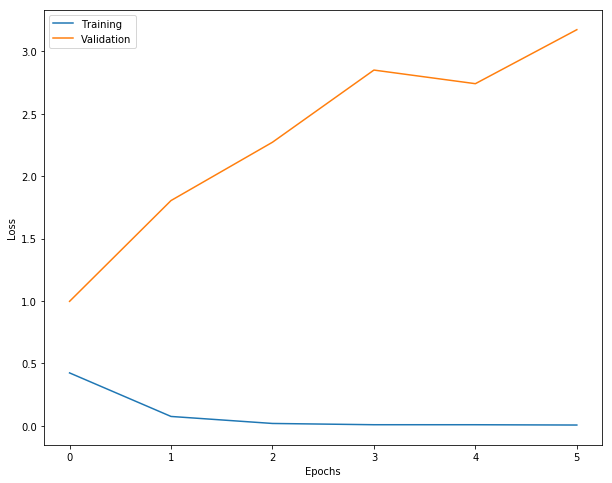

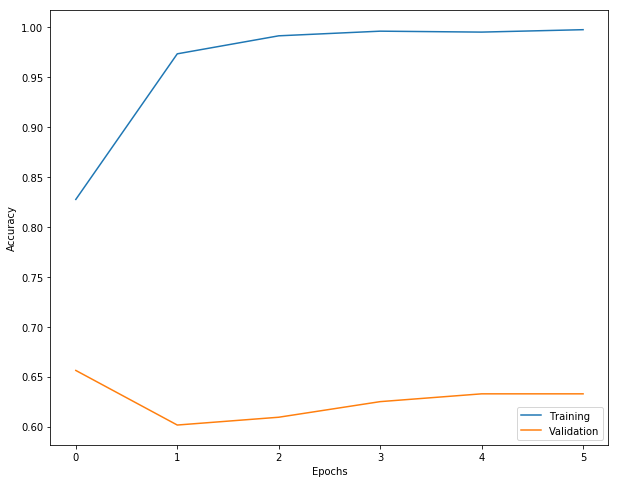

In [32]:
#Adagrad
epochs = 10
testModel('adagrad', epochs, "training model with adagrad")

### 2.3 Evaluating the CNNs performance

In [1]:
# Get test data
from functions import data
x_test, y_test = data.getTestData()
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

Test data shape:  (63, 224, 224, 3)
Test labels shape:  (63, 1)


In [2]:
X_test = x_test/255

In [3]:
# load and evaluate best model
from keras.models import load_model
best_model = load_model('4.4.h5')
best_model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
activation_6 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_7 (Activation)    (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 52, 52, 64)        18496     
__________

In [4]:
best_model.predict_classes(x_test)

array([[0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1]])

In [5]:
def printMetrics(fn, tp):
    sensitivity = tp/(tp+fn)
    
    print("True Positive Rate (TPR) or Hit Rate or Recall or Sensitivity: "
          , sensitivity)

tn is the true negative. These are scans classified correctly as not having malignant lesions.

fn is the false negative. These are scans classified incorrectly as having malignant lesions yet they are benign.

fn is the false negatives. These are images predicted as not having malignant lesions yet they do. This should be low.

tp is the true positive. These are correctly predicted to have malignant lesions. 


Sensitivity is a function of false negatives and true positives two variables. Because we are dealing with cancer, false negatives should be very low and true positives high. Low number of false negatives and a high number of true positives gives a high sensitivity. A high sensitivity is desired in a good model

In [6]:
# Evaluate all
from sklearn.metrics import confusion_matrix
expected = y_test
prediction = best_model.predict_classes(x_test)
tn,fp,fn,tp = confusion_matrix(y_test, prediction).ravel()
print("false negatives: ", fn)
print("true positives: ", tp)
print("true negatives: ", tn)
print("false positives: ", fp)
printMetrics(fn, tp)

false negatives:  11
true positives:  10
true negatives:  26
false positives:  16
True Positive Rate (TPR) or Hit Rate or Recall or Sensitivity:  0.47619047619


This is much lower than what we get with a more balanced dataset

### References for images and some content:

\[1\] [https://adeshpande3.github.io/adeshpande3.github.io/]() 
<br> \[2\] ["Neural Networks and Deep Learning"](http://neuralnetworksanddeeplearning.com/) by Michael Nielsen.
<br> \[3\] Deep learning with TensorFlow and Keras by Valerio Maggio